In [ ]:
!pip install opencv-python


     |████████████████████████████████| 95.4 MB 80.4 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

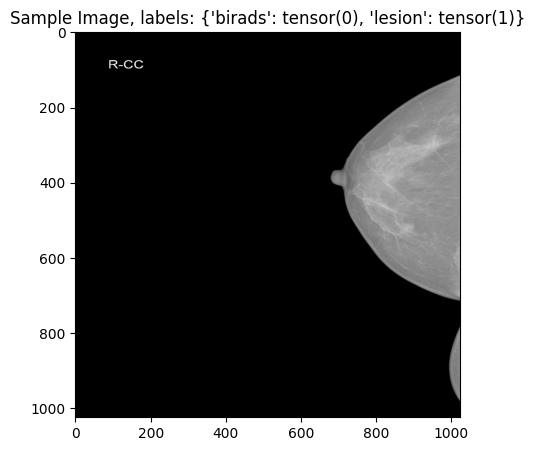

tensor(255.)


In [3]:
import os
import h5py
import torch
from torch.utils.data import Dataset
from glob import glob
import numpy as np
import cv2



class HDF5ChunkedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        PyTorch Dataset for reading chunked HDF5 files.

        Args:
            root_dir (str): Path to directory containing HDF5 chunks.
            transform (callable, optional): Optional transform to apply to each sample.
        """
        self.chunk_files = sorted(glob(os.path.join(root_dir, '*.h5')))
        self.transform = transform
        self.index_map = []

        self.chunk_sizes = []
        for chunk_idx, file in enumerate(self.chunk_files):
            with h5py.File(file, 'r') as f:
                n_samples = f['x'].shape[0]
                self.chunk_sizes.append(n_samples)
                self.index_map.extend([(chunk_idx, i) for i in range(n_samples)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        chunk_idx, local_idx = self.index_map[idx]
        file_path = self.chunk_files[chunk_idx]

        with h5py.File(file_path, 'r') as f:
            image = f['x'][local_idx]
            birads = f['y_birads'][local_idx]
            lesion = f['y_lesions'][local_idx]

        # Normalize or convert to torch tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Assuming grayscale
        birads = torch.tensor(birads, dtype=torch.long)
        lesion = torch.tensor(lesion, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, {'birads': birads, 'lesion': lesion}

train_path = '/media/nvidia/DATA2/datasets/prepared/vindr/1024_minmax/train'

test_dataset = HDF5ChunkedDataset(root_dir=train_path, transform=None)
sample = test_dataset[0]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(sample[0][0], cmap='gray')
plt.title('Sample Image, labels: ' + str(sample[1]))
plt.show()
print(sample[0][0].max())  # Print labels

In [ ]:
def build_pyramid(image, image_size):
  # resize the image by successive downsampling
  if image_size == 1024:
     levels = 1
  elif image_size == 512:
      levels = 2
  elif image_size == 256:
      levels = 3
  elif image_size == 128: 
        levels = 4
  else:
     print("Unsupported image size. Supported sizes are 1024, 512, 256, and 128.")
  pyramid = [image]
  for i in range(levels - 1):
      layered = cv2.pyrDown(image)
      pyramid.append(layered)
      image = layered

  return pyramid[-1]  


(128, 128)


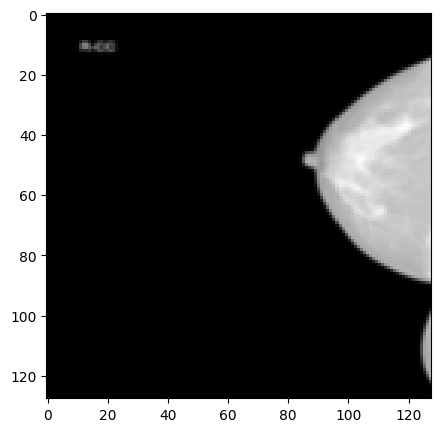

In [21]:
sample_pyramid = build_pyramid(np.array(sample[0][0]), 1024)

print(sample_pyramid.shape)
plt.figure(figsize=(10, 5))
plt.imshow(sample_pyramid, cmap='gray')

In [32]:


def clahe(img, clip=1.5):
    """
    Image enhancement using CLAHE. Converts float image to uint8.
    """
    img = img - np.min(img)
    if np.max(img) != 0:
        img = img / np.max(img)
    img = (img * 255).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(img)
    return cl

In [48]:
import h5py
import matplotlib.pyplot as plt

file_path = '/media/nvidia/DATA2/datasets/prepared/vindr/224_cropped_gabor/train/batch_0045.h5'
with h5py.File(file_path, 'r') as f:
    image = f['x'][:]
    birads = f['y_birads'][:]
    lesion = f['y_lesions'][:]

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/media/nvidia/DATA2/datasets/prepared/vindr/224_cropped_gabor/train/batch_0045.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

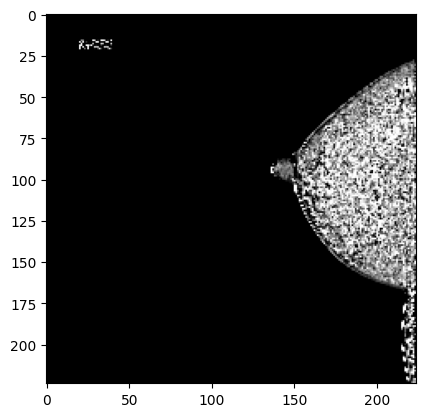

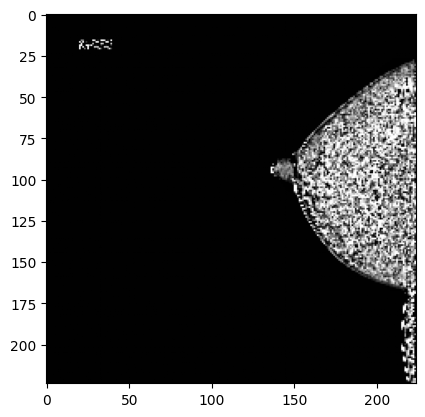

In [47]:
plt.imshow(image[4], cmap='gray')
plt.show()

plt.imshow(clahe(image[4], 2), cmap='gray')
plt.show()

In [3]:
import sys
sys.path.insert(0, '..')
from src.core.df_loaders.vindr import VindrDataframeLoader

df_loader = VindrDataframeLoader('/media/nvidia/DATA2/datasets/original/vindr')
df = df_loader.load()

In [5]:
df['train']['absolute_path']

KeyError: 'absolute_path'